<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Processing PCAP files

The first step is to process the PCAP files and extract the features. The main library I am using for this is scapy, but I am going to create some helper functions to make it easier to extract the features I want. The starting point for this code is taken from the githib repo [netml](https://github.com/noise-lab/netml), although I have modified it to suit this project. 

The overall technique I am employing in the notebook is translate the PCAP files into a set of sessions (flows), where a flow is defined by a 5-tuple (src IP, src port, dst IP, dst port, protocol). I am then extracting features from each flow, and then using these features to train a classifier. The classifier will then be used to predict whether a flow is malicious or not. Since an individual pcap file will usually be comprised of several flows, and extra step is required to combine the predictions for each flow into a single prediction for the pcap file. 

The following sets up the data locations and creates some lists of files to process.

In [ ]:
# Setup the training and validation dataset paths and create some lists of files.

BASE_PATH = Path(mdetect.__path__[0]).parent

DATA_PATH = BASE_PATH/ 'data'
MPATH = DATA_PATH / 'malware'
BPATH = DATA_PATH / 'benign'


malware_files = list(MPATH.glob('**/*.pcap'))
benign_files = list(BPATH.glob('**/*.pcap*'))

print(f'Number of malware files: {len(malware_files)}')
print(f'Number of benign files: {len(benign_files)}')

Number of malware files: 8
Number of benign files: 3


In [1]:
#| echo: false
#| output: asis
show_doc(flow_duration)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L53){target="_blank" style="float:right; font-size:smaller"}

### flow_duration

>      flow_duration (pkts:List)

The following defines the basic data structures for extracting flows from the PCAP files.

In [2]:
#| echo: false
#| output: asis
show_doc(PacketFlows)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L61){target="_blank" style="float:right; font-size:smaller"}

### PacketFlows

>      PacketFlows (pcap_file:pathlib.Path, interval:float=0,
>                   q_interval:float=0.9, min_pkts:int=2, tcp_timeout:int=600,
>                   udp_timeout:int=600, verbose:int=0)

In [ ]:
pf = PacketFlows(malware_files[2], min_pkts=2)
pf.summary()

pcap_file: /Users/khannay/work/cyber/mal_project/mdetect/data/malware/2023-01-05-Agent-Tesla-variant-traffic.pcap
Number of flows:  26
Number of packets in each flow:  [126, 490, 9, 13, 17, 23, 3, 3, 3, 13, 23, 15, 23, 11, 15, 3, 46, 51, 16, 10, 11, 29, 17, 17, 10, 13]


In [ ]:
pf_df = PacketFlows.pcap2pandas(malware_files[2])
pf_df.head()

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2023-01-05 16:51:00,None,None,None,NaN,None,NaN,False,42,ff:ff:ff:ff:ff:ff,281474976710655,00:14:78:37:9b:f6,87916256246,NaN,NaN,None,1672959060.081370,0.000000
1,2023-01-05 16:51:00,None,None,None,NaN,None,NaN,False,42,00:14:78:37:9b:f6,87916256246,bc:ea:fa:22:74:fb,207717404931323,NaN,NaN,None,1672959060.081505,0.000135
2,2023-01-05 16:51:00,"(savory.com.bd.,)",None,192.168.1.1,3.232236e+09,192.168.1.27,3.232236e+09,True,73,00:14:78:37:9b:f6,87916256246,bc:ea:fa:22:74:fb,207717404931323,53.0,56742.0,UDP,1672959060.220437,0.139067
3,2023-01-05 16:51:00,"(savory.com.bd.,)","(savory.com.bd.,)",192.168.1.27,3.232236e+09,192.168.1.1,3.232236e+09,True,89,bc:ea:fa:22:74:fb,207717404931323,00:14:78:37:9b:f6,87916256246,56742.0,53.0,UDP,1672959060.238688,0.157318
4,2023-01-05 16:51:00,None,None,45.56.99.101,7.586702e+08,192.168.1.27,3.232236e+09,False,66,00:14:78:37:9b:f6,87916256246,bc:ea:fa:22:74:fb,207717404931323,80.0,51952.0,TCP,1672959060.243743,0.162373


Now we can start adding functions to extract features from the flows. The first function records the TCP flags that are set in the flow, by counting the number of packets with each flag set. This creates a vector of 8 features, one for each flag. The idea is that this gives a way of distinguishing between different types of TCP connections.

I am making use of the `patch` decorator from the fastcore library (fastai). This just allows me to add a new method to the Flow class, without having to modify the original class definition. 

In [3]:
#| echo: false
#| output: asis
show_doc(PacketFlows.header_features)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L466){target="_blank" style="float:right; font-size:smaller"}

### PacketFlows.header_features

>      PacketFlows.header_features ()

Quick visual of the TCP flags aggregated across each pcap capture.

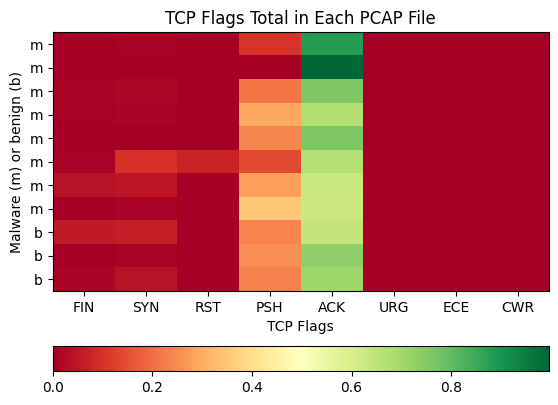

In [ ]:
flags_total = np.zeros((len(malware_files) + len(benign_files), len(FLAG_NAMES)))

for (idx, pcap) in enumerate(malware_files + benign_files):
    pf = PacketFlows(pcap, min_pkts=2, verbose=0)
    hf = pf.header_features()
    flags_total[idx] = np.sum(hf, axis=0)
    flags_total[idx] /= np.sum(flags_total[idx]) # normalize 
    
flags_total = np.array(flags_total)
fig, ax = plt.subplots()
im = ax.imshow(flags_total, cmap='RdYlGn', aspect='auto')
ax.set_yticks(np.arange(flags_total.shape[0]))
ax.set_yticklabels(['m' for _ in range(len(malware_files))] + ['b' for _ in range(len(benign_files))]);
ax.set_xticks(np.arange(len(FLAG_NAMES)))
ax.set_xticklabels(FLAG_NAMES);
ax.set_title('TCP Flags Total in Each PCAP File')
ax.set_xlabel('TCP Flags')
ax.set_ylabel('Malware (m) or benign (b)')

fig.colorbar(im, ax=ax, orientation='horizontal');

This is a function that can be used to pull out any plain text http requests like a 'GET' or 'POST' request. This didn't end up being used in the final model, but I left it in here for reference.

In [4]:
#| echo: false
#| output: asis
show_doc(PacketFlows.count_http_raw_occurances)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L487){target="_blank" style="float:right; font-size:smaller"}

### PacketFlows.count_http_raw_occurances

>      PacketFlows.count_http_raw_occurances (filter:bytes)

Example usage for the http request function.

In [ ]:
pf.count_http_raw_occurances(filter = b'GET') # find flows with GET requests

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 2., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In this next section we define some additional functions for computing features from the flows. These are based on the features used in the [netml]. 

In [5]:
#| echo: false
#| output: asis
show_doc(PacketFlows.stats_features_names)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L578){target="_blank" style="float:right; font-size:smaller"}

### PacketFlows.stats_features_names

>      PacketFlows.stats_features_names ()

In [6]:
#| echo: false
#| output: asis
show_doc(PacketFlows.stats_features)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L545){target="_blank" style="float:right; font-size:smaller"}

### PacketFlows.stats_features

>      PacketFlows.stats_features (flows:__main__.PacketFlows)

get basic stats features, which includes duration, pkts_rate, bytes_rate, mean,
median, std, q1, q2, q3, min, and max.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| flows | PacketFlows |  |
| **Returns** | **array** | **stats** |

In [7]:
#| echo: false
#| output: asis
show_doc(PacketFlows.size_features)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L525){target="_blank" style="float:right; font-size:smaller"}

### PacketFlows.size_features

>      PacketFlows.size_features ()

Extract packet sizes features from flows
Parameters
----------

In [8]:
#| echo: false
#| output: asis
show_doc(PacketFlows.IAT_features)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L506){target="_blank" style="float:right; font-size:smaller"}

### PacketFlows.IAT_features

>      PacketFlows.IAT_features ()

Extract interarrival times (IAT) features from flows.
Parameters
----------

## Exploratory Data Analysis

We begin by loading in the data and trying to gain some understanding of the data.

In [ ]:
def load_malware_pcap() -> pd.DataFrame:
    df = pd.DataFrame()
    for file in malware_files:
        pdf = PacketFlows.pcap2pandas(file)
        pdf['capture'] = file.name
        pdf['label'] = 1.0
        df = pd.concat([df,pdf], ignore_index=True)
    return df

def load_benign_pcap() -> pd.DataFrame:
    df = pd.DataFrame()
    for file in benign_files:
        pdf = PacketFlows.pcap2pandas(file)
        pdf['capture'] = file.name
        pdf['label'] = 0.0
        df = pd.concat([df,pdf], ignore_index=True)
    return df

In [ ]:
# Load the data into Pandas DataFrames for quick analysis.
mdata = load_malware_pcap()
bdata = load_benign_pcap()

print(f"Malware data shape: {mdata.shape}, and benign data shape: {bdata.shape}")

Decode error with {pkt.summary()}
Malware data shape: (167242, 20), and benign data shape: (61059, 20)


In [ ]:
mdata.capture.value_counts(normalize=True)

2023-03-07-Emotet-epoch4-infection-with-spambot-traffic-carved.pcap           0.451723
2023-01-16-IcedID-infection-with-Backonnect-and-VNC-and-Cobalt-Strike.pcap    0.150453
2023-03-18-Emotet-E5-infection-traffic.pcap                                   0.118959
2023-04-13-MetaStealer-C2-traffic.pcap                                        0.118702
2022-09-21-Astaroth-Guildma-infection.pcap                                    0.080901
2022-12-07-Bumblebee-infection-with-Cobalt-Strike.pcap                        0.039344
2022-01-04-Remcos-RAT-infection-traffic.pcap                                  0.033646
2023-01-05-Agent-Tesla-variant-traffic.pcap                                   0.006272
Name: capture, dtype: float64

In [ ]:
mdata.protocol.value_counts(normalize=True)

TCP     0.989466
UDP     0.009907
ICMP    0.000627
Name: protocol, dtype: float64

In [ ]:
bdata.protocol.value_counts(normalize=True)

TCP     0.570188
UDP     0.383077
ICMP    0.046735
Name: protocol, dtype: float64

In [ ]:
mdata.groupby(["capture", "protocol"]).size().reset_index(name="Counts")

,capture,protocol,Counts
0,2022-01-04-Remcos-RAT-infection-traffic.pcap,TCP,5621
1,2022-01-04-Remcos-RAT-infection-traffic.pcap,UDP,6
2,2022-09-21-Astaroth-Guildma-infection.pcap,TCP,13232
3,2022-09-21-Astaroth-Guildma-infection.pcap,UDP,243
4,2022-12-07-Bumblebee-infection-with-Cobalt-Str...,TCP,6209
5,2022-12-07-Bumblebee-infection-with-Cobalt-Str...,UDP,249
6,2023-01-05-Agent-Tesla-variant-traffic.pcap,TCP,998
7,2023-01-05-Agent-Tesla-variant-traffic.pcap,UDP,41
8,2023-01-16-IcedID-infection-with-Backonnect-an...,TCP,24970
9,2023-01-16-IcedID-infection-with-Backonnect-an...,UDP,78


In [ ]:
mdata.groupby(["capture", "port_dst"]).size().reset_index(name="Counts").sort_values(by='Counts',ascending=False).head(10)

,capture,port_dst,Counts
858,2023-03-07-Emotet-epoch4-infection-with-spambo...,465.0,16125
1949,2023-04-13-MetaStealer-C2-traffic.pcap,49825.0,12479
669,2023-01-16-IcedID-infection-with-Backonnect-an...,64823.0,8050
596,2023-01-16-IcedID-infection-with-Backonnect-an...,8080.0,7826
859,2023-03-07-Emotet-epoch4-infection-with-spambo...,587.0,7545
1947,2023-04-13-MetaStealer-C2-traffic.pcap,1775.0,7310
1117,2023-03-07-Emotet-epoch4-infection-with-spambo...,64234.0,6164
1081,2023-03-07-Emotet-epoch4-infection-with-spambo...,64164.0,6043
139,2022-09-21-Astaroth-Guildma-infection.pcap,49790.0,5885
1090,2023-03-07-Emotet-epoch4-infection-with-spambo...,64173.0,5562


In [ ]:
mdata.groupby(["capture", "port_src"]).size().reset_index(name="Counts").sort_values(by='Counts',ascending=False).head(10)

,capture,port_src,Counts
868,2023-03-07-Emotet-epoch4-infection-with-spambo...,465.0,18848
2008,2023-04-13-MetaStealer-C2-traffic.pcap,1775.0,12529
869,2023-03-07-Emotet-epoch4-infection-with-spambo...,587.0,9234
606,2023-01-16-IcedID-infection-with-Backonnect-an...,8080.0,8390
679,2023-01-16-IcedID-infection-with-Backonnect-an...,64823.0,7557
2010,2023-04-13-MetaStealer-C2-traffic.pcap,49825.0,7253
19,2022-09-21-Astaroth-Guildma-infection.pcap,80.0,6610
870,2023-03-07-Emotet-epoch4-infection-with-spambo...,7080.0,6543
871,2023-03-07-Emotet-epoch4-infection-with-spambo...,8080.0,6437
1093,2023-03-07-Emotet-epoch4-infection-with-spambo...,64164.0,5213


In [ ]:
mdata.describe()

,ip_dst_int,ip_src_int,length,mac_dst_int,mac_src_int,port_dst,port_src,label
count,1.657070e+05,1.657070e+05,167242.000000,1.672420e+05,1.672420e+05,165737.000000,165737.000000,167242.0
mean,1.637467e+09,1.809889e+09,712.858606,2.865872e+13,2.656908e+13,36881.798778,24398.298775,1.0
std,1.273197e+09,1.183365e+09,687.362543,6.278353e+13,5.474226e+13,27956.455094,27928.376870,0.0
min,9.897851e+07,0.000000e+00,42.000000,1.280447e+10,1.280447e+10,25.000000,25.000000,1.0
25%,1.685605e+08,6.237032e+08,54.000000,1.280447e+10,4.842871e+10,587.000000,465.000000,1.0
50%,1.738531e+09,1.746220e+09,207.000000,4.842871e+10,4.842871e+10,49825.000000,8080.000000,1.0
75%,2.886730e+09,2.886730e+09,1514.000000,2.683002e+13,2.683002e+13,64110.000000,51414.000000,1.0
max,4.294967e+09,3.681890e+09,1514.000000,2.814750e+14,2.134394e+14,65470.000000,65470.000000,1.0


In [ ]:
bdata.describe()

,ip_dst_int,ip_src_int,length,mac_dst_int,mac_src_int,port_dst,port_src,label
count,4.613000e+04,4.613000e+04,61059.000000,6.105900e+04,6.105900e+04,49627.000000,49627.000000,61059.0
mean,1.719452e+09,1.961301e+09,477.937536,9.258988e+13,8.469094e+13,24864.186532,21782.784633,0.0
std,1.456205e+09,1.277887e+09,587.062218,9.019149e+13,8.747990e+13,25338.449216,25432.119090,0.0
min,1.684301e+07,0.000000e+00,42.000000,0.000000e+00,0.000000e+00,13.000000,13.000000,0.0
25%,1.678383e+08,4.000452e+08,78.000000,1.101089e+12,8.796758e+12,631.000000,443.000000,0.0
50%,1.418889e+09,2.454412e+09,134.000000,6.638738e+13,6.200099e+13,7078.000000,5690.000000,0.0
75%,3.232237e+09,3.232237e+09,981.000000,1.812115e+14,1.812115e+14,55545.000000,54293.000000,0.0
max,4.294967e+09,3.640661e+09,8814.000000,2.814750e+14,2.758225e+14,65535.000000,65535.000000,0.0


## Training a model

First we define a few wrapper functions to generate the data. The first function generates a specific set of features using the flows derived from a pcap file. 

In [9]:
#| echo: false
#| output: asis
show_doc(collect_flow_stats)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L594){target="_blank" style="float:right; font-size:smaller"}

### collect_flow_stats

>      collect_flow_stats (pcap_file:pathlib.Path)

In [ ]:
df_test = collect_flow_stats(malware_files[2])

df_test.shape

(26, 68)

In [ ]:
df_test.columns

Index(['duration', 'pkts_rate', 'bytes_rate', 'mean_size', 'std_sizes',
       'q1_sizes', 'q2_sizes', 'q3_sizes', 'min_sizes', 'max_sizes',
       'num_pkts', 'num_bytes', 'flags_FIN', 'flags_SYN', 'flags_RST',
       'flags_PSH', 'flags_ACK', 'flags_URG', 'flags_ECE', 'flags_CWR',
       'protocol_udp', 'protocol_icmp', 'src_port_21', 'src_port_22',
       'src_port_23', 'src_port_25', 'src_port_53', 'src_port_80',
       'src_port_110', 'src_port_143', 'src_port_443', 'src_port_465',
       'src_port_587', 'src_port_993', 'src_port_995', 'src_port_3306',
       'src_port_3389', 'src_port_5432', 'src_port_8080', 'src_port_67',
       'src_port_68', 'src_port_123', 'src_port_161', 'src_port_500',
       'src_port_514', 'dst_port_21', 'dst_port_22', 'dst_port_23',
       'dst_port_25', 'dst_port_53', 'dst_port_80', 'dst_port_110',
       'dst_port_143', 'dst_port_443', 'dst_port_465', 'dst_port_587',
       'dst_port_993', 'dst_port_995', 'dst_port_3306', 'dst_port_3389',
       'dst_p

Aggregate the features into (X,y) and add the labels (1) for Malware and (0) for Benign.

In [10]:
#| echo: false
#| output: asis
show_doc(load_training_validation)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L634){target="_blank" style="float:right; font-size:smaller"}

### load_training_validation

>      load_training_validation (malware_path:pathlib.Path,
>                                benign_path:pathlib.Path, load:bool=True,
>                                save:bool=True, store_path=None, *args,
>                                **kwargs)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| malware_path | Path |  | Path to Malware samples |
| benign_path | Path |  | Path to Benign samples |
| load | bool | True | Load the data from disk if already built |
| save | bool | True | Save the data to disk, can be used for quick loading later |
| store_path | NoneType | None | Path to store the data |
| args |  |  |  |
| kwargs |  |  |  |
| **Returns** | **Tuple** |  |  |

In [11]:
#| echo: false
#| output: asis
show_doc(hash_datafiles)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L630){target="_blank" style="float:right; font-size:smaller"}

### hash_datafiles

>      hash_datafiles (filelist:List[pathlib.Path])

In [ ]:
X,y = load_training_validation(MPATH, BPATH, load=False, save=True)
print(X.shape)

Saving data to disk as /Users/khannay/work/cyber/mal_project/mdetect/data/tmp/60d7abcb2da00a00069cf43addb167a6_273fdb98291fb163611e9eff0868ceda/transformed_data_60d7abcb2da00a00069cf43addb167a6_273fdb98291fb163611e9eff0868ceda.parquet.gz
(4345, 68)


In [ ]:
X.columns

Index(['duration', 'pkts_rate', 'bytes_rate', 'mean_size', 'std_sizes',
       'q1_sizes', 'q2_sizes', 'q3_sizes', 'min_sizes', 'max_sizes',
       'num_pkts', 'num_bytes', 'flags_FIN', 'flags_SYN', 'flags_RST',
       'flags_PSH', 'flags_ACK', 'flags_URG', 'flags_ECE', 'flags_CWR',
       'protocol_udp', 'protocol_icmp', 'src_port_21', 'src_port_22',
       'src_port_23', 'src_port_25', 'src_port_53', 'src_port_80',
       'src_port_110', 'src_port_143', 'src_port_443', 'src_port_465',
       'src_port_587', 'src_port_993', 'src_port_995', 'src_port_3306',
       'src_port_3389', 'src_port_5432', 'src_port_8080', 'src_port_67',
       'src_port_68', 'src_port_123', 'src_port_161', 'src_port_500',
       'src_port_514', 'dst_port_21', 'dst_port_22', 'dst_port_23',
       'dst_port_25', 'dst_port_53', 'dst_port_80', 'dst_port_110',
       'dst_port_143', 'dst_port_443', 'dst_port_465', 'dst_port_587',
       'dst_port_993', 'dst_port_995', 'dst_port_3306', 'dst_port_3389',
       'dst_p

Create the train-test split and print out the number of samples in each set. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Show the sizes of the training and test sets
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

# Show the balance of labels in the training and test sets
print("Training set has {} malware samples.".format(sum(y_train)))
print("Training set has {} legitimate samples.".format(len(y_train) - sum(y_train)))

Training set has 3041 samples.
Test set has 1304 samples.
Training set has 2060 malware samples.
Training set has 981 legitimate samples.


This tells us that the malware sample flows are twice as common as the benign samples in our dataset. This next plot attempts to do a low dimensional embedding of the features (2 dimensions) and then overlays the labels. This is just to get a sense of whether the features are separable. This plot demonstrates that the features are not linearly separable or low dimensional in nature, so we will need to use a non-linear classifier.

/Users/khannay/miniconda3/envs/malware-detect/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/khannay/miniconda3/envs/malware-detect/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


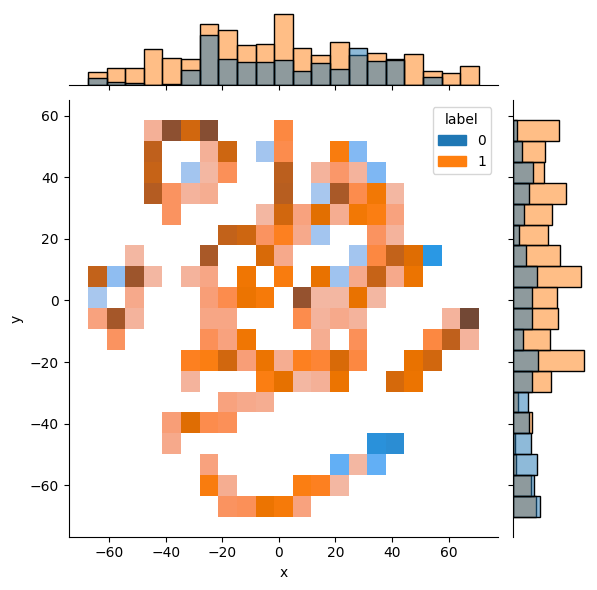

In [ ]:
# Create an tsne embedding of the data and show the labels from y_train 

TSNE_model = TSNE(n_components=2, random_state=42)
X_embedded = TSNE_model.fit_transform(X_train.to_numpy())

df_tsne = pd.DataFrame({ 'x': X_embedded[:,0], 'y': X_embedded[:,1], 'label': y_train })
sns.jointplot(data=df_tsne, x="x", y="y", hue="label", kind="hist");

## Training models

Next we will train some classifier models using these processed features. The first step is to create some data structures for holding the results and running the training loops. 

In [12]:
#| echo: false
#| output: asis
show_doc(ModelMetrics)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L718){target="_blank" style="float:right; font-size:smaller"}

### ModelMetrics

>      ModelMetrics (modelcand:__main__.ModelCandidate, accuracy_score:float,
>                    cv_scores:numpy.ndarray, auc_score:float, f1_score:float,
>                    confusion_matrix:numpy.ndarray)

A dataclass to hold a fitted model and routines to compute and plot its metrics.

In [13]:
#| echo: false
#| output: asis
show_doc(ModelCandidate)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L710){target="_blank" style="float:right; font-size:smaller"}

### ModelCandidate

>      ModelCandidate (model:Any, name:str)

A dataclass to hold a model and its name useful for keeping track of models and plotting routines

This function will actually train the model and compute some evaluation metrics. 

In [14]:
#| echo: false
#| output: asis
show_doc(evaluate)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L787){target="_blank" style="float:right; font-size:smaller"}

### evaluate

>      evaluate (candidate:__main__.ModelCandidate, X_train:numpy.ndarray,
>                y_train:numpy.ndarray, X_test:numpy.ndarray,
>                y_test:numpy.ndarray)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| candidate | ModelCandidate | Pipeline with a name attribute and a model attribute |
| X_train | ndarray | Training data input features |
| y_train | ndarray | Training data labels (1= malware, 0 = benign) |
| X_test | ndarray | Test data input features |
| y_test | ndarray | Test data labels (1= malware, 0 = benign) |
| **Returns** | **ModelMetrics** |  |

Here we actually build some pipelines to evaluate some model architectures. I am rescaling the numerical features and passing in the remaining categorical features as dummy coded variables. Since the Support Vector Machine and k-Nearst Neighbors models are sensitive to the scale of the features, I am removing the categorical features from these models.

In [ ]:
category_features = list(range(20, X.shape[1])) # All features are categorical except the first 20 

# Define a baseline pipeline that scales the numeric features and leaves the categorical features unchanged
baseline_pipe = [('scale', ColumnTransformer([('scaler', StandardScaler(), slice(0, 20))], remainder='passthrough'))]

# Define a pipeline that scales the numeric features and drops the categorical features for use with models that don't support categorical features
numeric_pipe = [('scale', ColumnTransformer([('scaler', StandardScaler(), slice(0, 20))], remainder='drop'))]

# Create the pipelines for each model along with metaparameters 
svm_pipe = Pipeline( numeric_pipe + [('model', SVC(random_state=42, probability=True, kernel='rbf'))])
logreg_pipe = Pipeline(baseline_pipe + [('model', LogisticRegression(max_iter=10_000))])
rf_pipe = Pipeline(baseline_pipe + [('model', RandomForestClassifier(n_estimators = 30, random_state=42))])
xgb_pipe = Pipeline(baseline_pipe + [('model', xgb.XGBClassifier(random_state=42, 
                                                                 eval_metric='logloss', 
                                                                 learning_rate=0.3,
                                                                 max_depth=6,
                                                                 n_estimators=100,))])
knn_pipe3 = Pipeline(numeric_pipe + [('model', KNeighborsClassifier(n_neighbors=3))])
knn_pipe5 = Pipeline(numeric_pipe + [('model', KNeighborsClassifier(n_neighbors=5))])

In [ ]:
# Create a list of candidate models to evaluate 

candidate_models = [ ModelCandidate(xgb_pipe, "XGBoost"),
                    ModelCandidate(rf_pipe, "Random Forest"),
                    ModelCandidate(knn_pipe3, "KNN-3"),
                    ModelCandidate(knn_pipe5, "KNN-5"),
                    ModelCandidate(svm_pipe, "SVM"),
                    ModelCandidate(logreg_pipe, "Logistic Regression"),
                    ]

Actually fit the models for evaluation.

In [ ]:
fit_models = [evaluate(model, X_train, y_train, X_test, y_test) for model in candidate_models]

Make a confusion matrix for each model, showing the percentage of correctly classified samples.

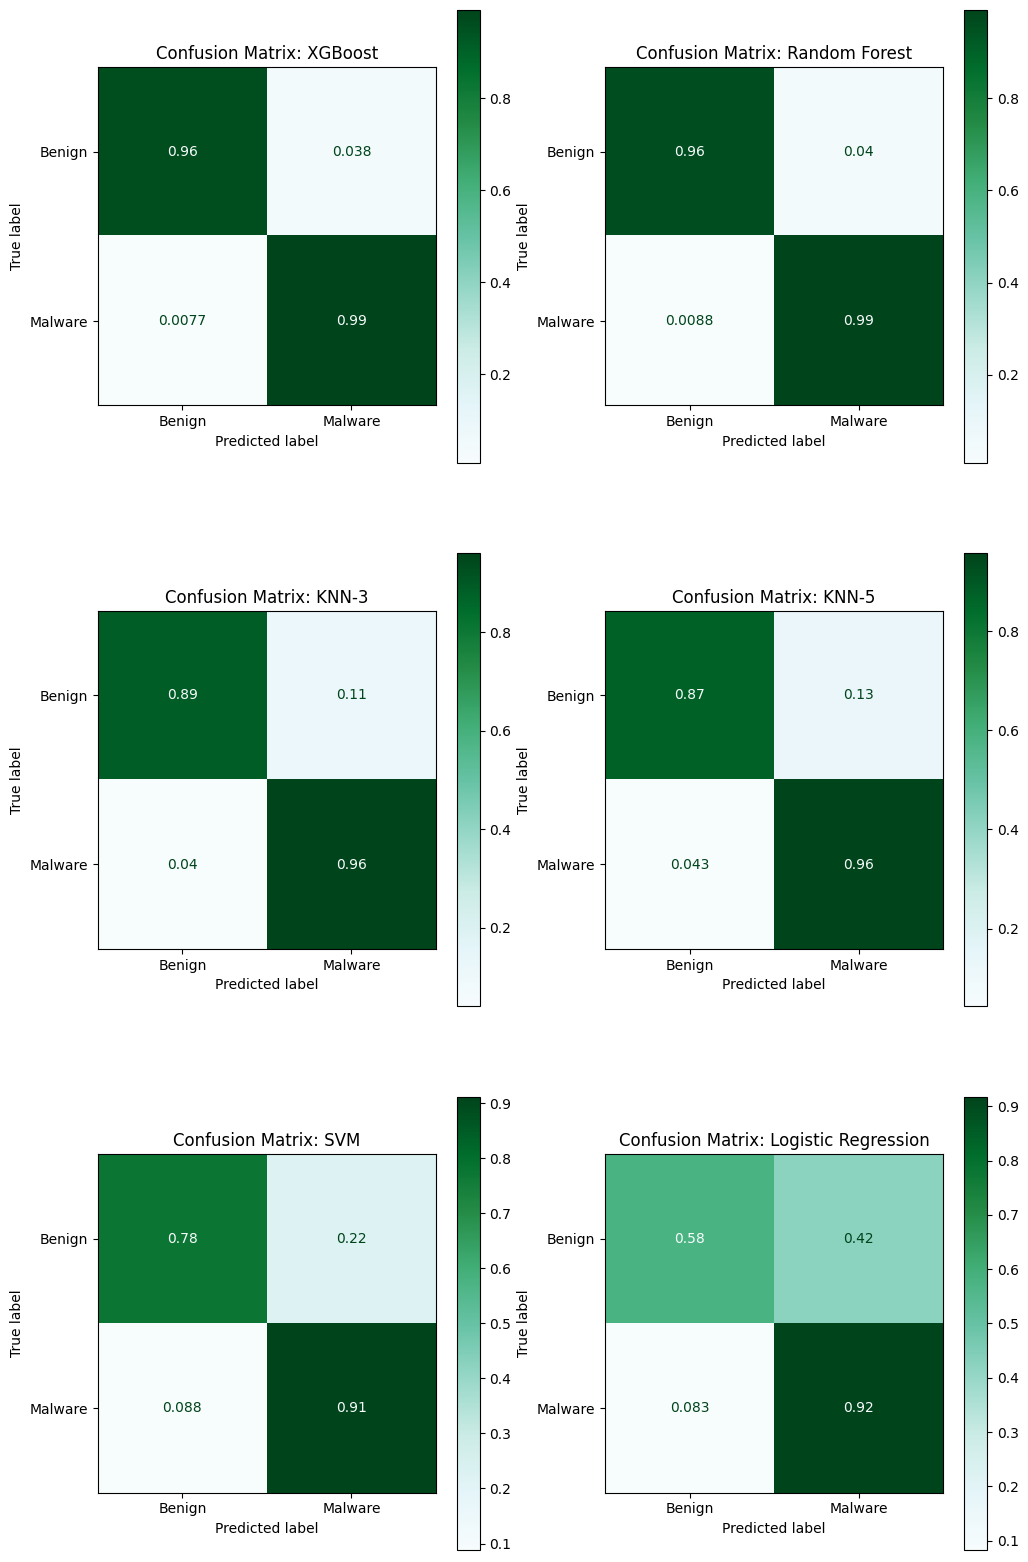

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (12,20), squeeze=False)

for idx, model in enumerate(fit_models):
    model.plot_confusion_matrix(ax=fig.axes[idx])
    
plt.savefig('../img/confusion.png') # save for the report

Next we show the ROC curves for each model. ROC curves are a way of visualizing the tradeoff between the true positive rate and the false positive rate for a classifier. The area under the curve (AUC) is a measure of the overall performance of the classifier. The higher the AUC the better the classifier. 

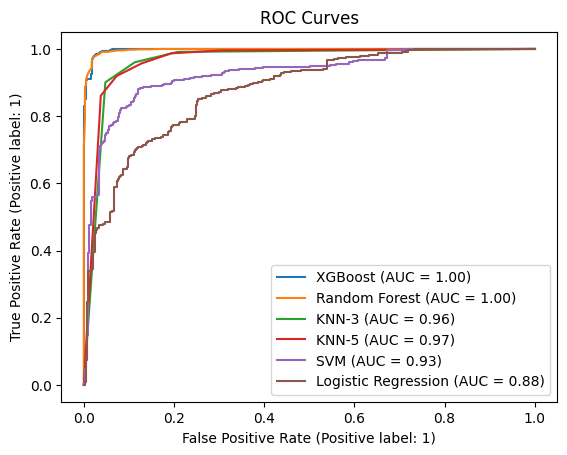

In [ ]:
for fitmodel in fit_models:
    fitmodel.plot_roc_curve(X_test, y_test, ax=plt.gca())
plt.savefig('../img/roc.png') # save for the report

The calibration measures the accuracy of the probability values returned by the model. A well calibrated model will return probability values that are close to the true probability of the event. In this case each of the models are pretty well calibrated. 

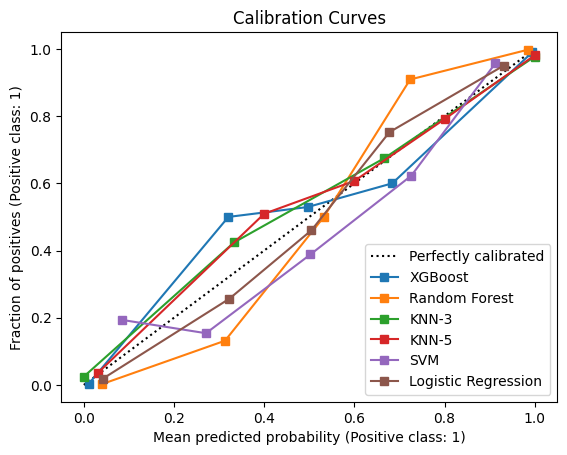

In [ ]:
for model in fit_models:
    model.plot_calibration_curve(X_test, y_test, ax=plt.gca())

plt.savefig('../img/calibration.png') # save for the report

Finally we can look at the cross validated accuracy scores for each model. I applied a five-fold cross validation to each model. One important component to note is the small standard deviation in the accuracy scores. This indicates that the models are not overfitting the data.

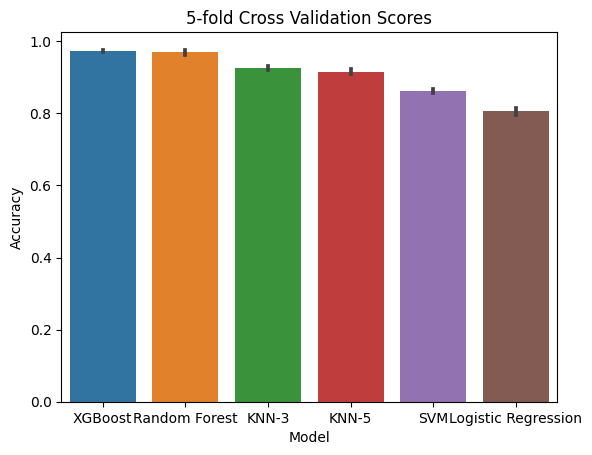

In [ ]:
# Cross validation scores

df_cv = pd.DataFrame([{'model': model.modelcand.name, 'cv_score': score} for model in fit_models for score in model.cv_scores])

ax = plt.gca()
sns.barplot(data=df_cv, x='model', y='cv_score', ax=ax)
ax.set_title("5-fold Cross Validation Scores")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model");
plt.savefig('../img/cv.png') # save for the report

The below shows the relative importances of the features in the XGBoost model. We only show the features with non-zero importance. With a larger training set we could use this analysis to remove features that are not contributing to the model performance.

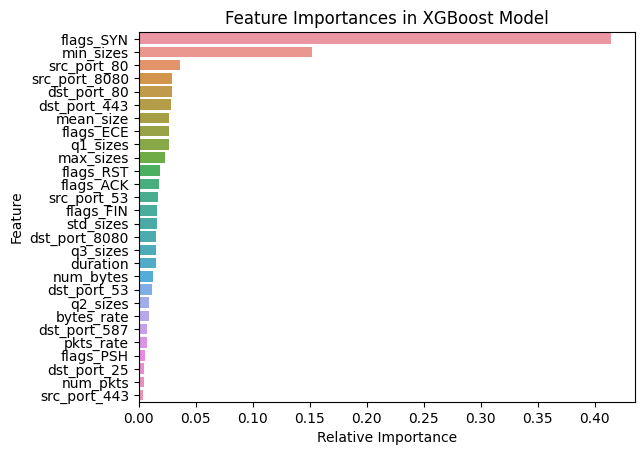

In [ ]:
xg_model_feature_importances = fit_models[0].modelcand.model['model'].feature_importances_
idx_nonzero = np.nonzero(xg_model_feature_importances)[0] 
importance_labels = X_train.columns[idx_nonzero] 
importances_nonzero = xg_model_feature_importances[idx_nonzero]

# Reorder the features by importance
importances_nonzero, importance_labels = zip(*sorted(zip(importances_nonzero, importance_labels), reverse=True))

importances_nonzero = np.array(importances_nonzero)
importance_labels = np.array(importance_labels)
ax = plt.gca()
sns.barplot(x=importances_nonzero, y=importance_labels, ax=ax)
ax.set_title("Feature Importances in XGBoost Model") 
ax.set_xlabel("Relative Importance") 
ax.set_ylabel("Feature"); 
plt.savefig('../img/importances.png') # save for the report

## Test Sets

As a final evaluation, we will test the models on a set of test data that was not used in training or validation. I downloaded a malware pcap not used in the training [available here](https://malware-traffic-analysis.net/2022/01/07/index.html) and some benign pcaps. The below shows the percentage of flows that were correctly classified as malware or benign.

In [15]:
#| echo: false
#| output: asis
show_doc(test_eval)

---

[source](https://github.com/khannay/mdetect/blob/main/mdetect/core.py#L817){target="_blank" style="float:right; font-size:smaller"}

### test_eval

>      test_eval (malware:bool=True)

In [ ]:
df_malware = test_eval(malware=True)
print("-----------------")
df_benign = test_eval(malware=False)

Model XGBoost has accuracy 0.98 on malware test data flows
Model Random Forest has accuracy 0.96 on malware test data flows
Model KNN-3 has accuracy 0.92 on malware test data flows
Model KNN-5 has accuracy 0.92 on malware test data flows
Model SVM has accuracy 0.87 on malware test data flows
Model Logistic Regression has accuracy 0.89 on malware test data flows
-----------------
Model XGBoost has accuracy 0.94 on benign test data flows
Model Random Forest has accuracy 0.94 on benign test data flows
Model KNN-3 has accuracy 0.77 on benign test data flows
Model KNN-5 has accuracy 0.74 on benign test data flows
Model SVM has accuracy 0.67 on benign test data flows
Model Logistic Regression has accuracy 0.52 on benign test data flows


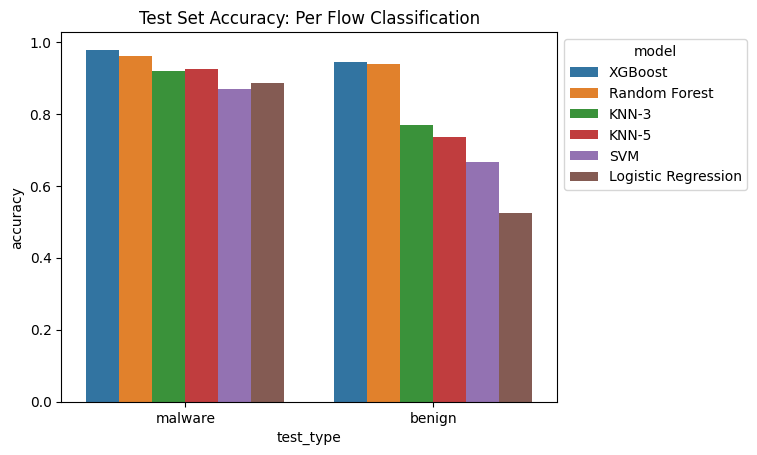

In [ ]:
df_test = pd.concat([df_malware, df_benign], axis=0)
ax=plt.gca()
sns.barplot(data=df_test, x='test_type', y='accuracy', hue='model', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("Test Set Accuracy: Per Flow Classification");
plt.savefig('../img/test_set.png') # save for the report